In [1]:
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
from metric import *
from utils import * 

In [2]:
dataroot = '/data/voc2012'
SAVE_DIR = '/data/model'

In [3]:
def to_tensor_target(img):
  img = np.array(img)
  # border
  img[img==255] = 0 # border = background 
  return torch.LongTensor(img)


size = (513,513)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
transform_input = transforms.Compose([
                                   transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

transform_mask = transforms.Compose([
                                   transforms.Resize(size),
                                   transforms.Lambda(to_tensor_target)
                                   ])

In [4]:
train_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='train', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

val_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='val', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


In [5]:
batch_size = 1

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)


device : cuda:0


## Load model

In [6]:
! ls /data/model

SVM_transfer_30_voc.pt		deeplabv3_autosupervised_voc07.pt  fcn32_bn.pt
cnn_classif_transfer_30_voc.pt	deeplabv3_unsupervised_voc.pt	   fcn8.pt
deeplabv3_10_autosup_voc.pt	deeplabv3_voc.pt		   fcn8_bn.pt
deeplabv3_30_semisup_voc.pt	fcn16.pt			   iou
deeplabv3_30_voc.pt		fcn16_bn.pt			   loss
deeplabv3_50_voc.pt		fcn32.pt


In [7]:
def load_model(file=None):
    if file is None:
        model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
        model.to(device)
    else:
        model = torch.load(os.path.join(SAVE_DIR,file))
    return model

In [8]:
model = load_model('deeplabv3_30_semisup_voc.pt')
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/workspace/utils.py:135: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/workspace/utils.py:137: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


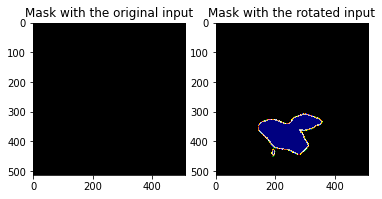

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9365882759747539


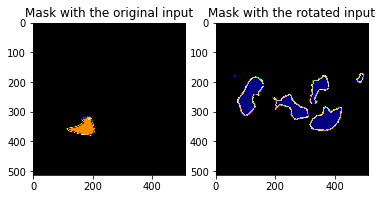

predicted classes with the original input :  ['background', 'car', 'motorbike', 'person']
predicted classes with the rotated input  :  ['background', 'motorbike', 'person']
accuracy : 0.9136638433858091


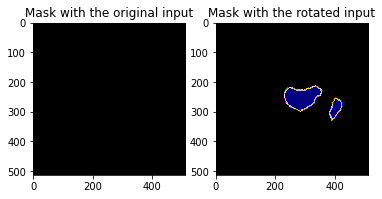

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9652352670717296


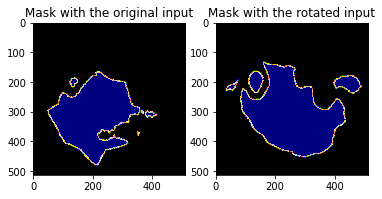

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.8464560795534428


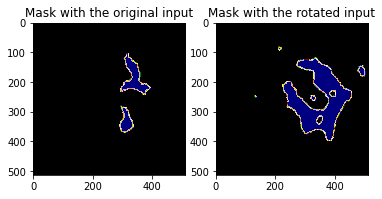

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9119425160258237


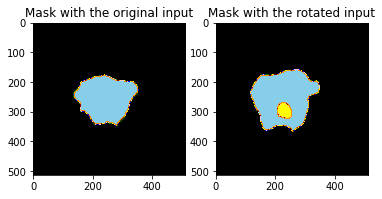

predicted classes with the original input :  ['background', 'cat']
predicted classes with the rotated input  :  ['background', 'bird', 'cat']
accuracy : 0.9511910597372791


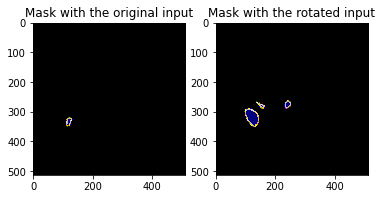

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9911843720195008


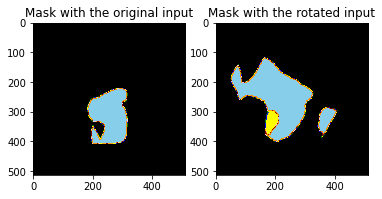

predicted classes with the original input :  ['background', 'cat']
predicted classes with the rotated input  :  ['background', 'bird', 'cat']
accuracy : 0.8727053718333087


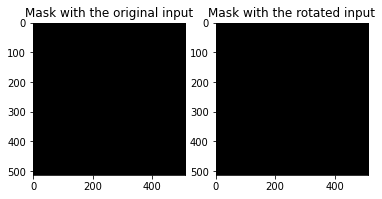

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background']
accuracy : 1.0


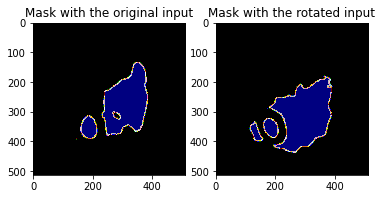

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'cat', 'person']
accuracy : 0.930945514099305


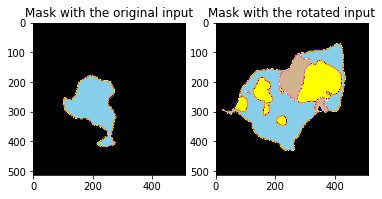

predicted classes with the original input :  ['background', 'cat']
predicted classes with the rotated input  :  ['background', 'bird', 'cat', 'dog', 'person']
accuracy : 0.7611610790024661


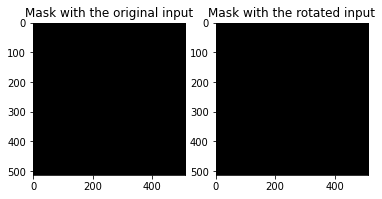

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background']
accuracy : 1.0


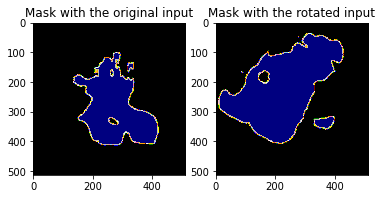

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.7664580554700592


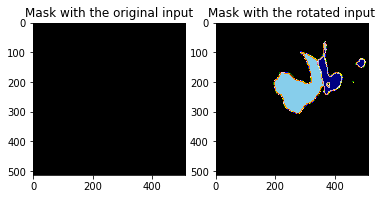

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background', 'cat', 'person']
accuracy : 0.9127708810688189


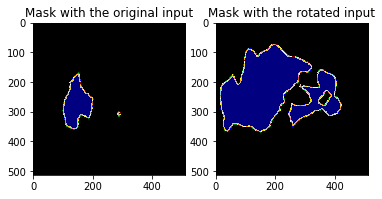

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.7908378266437156


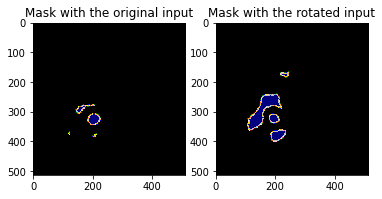

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9717443923866412


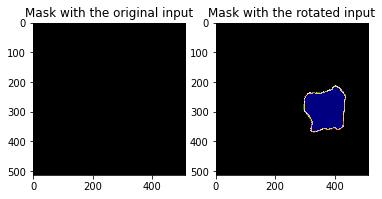

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9378726217753611


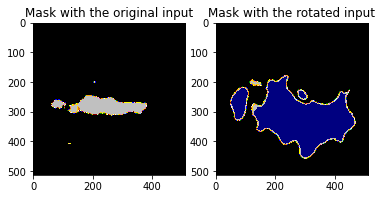

predicted classes with the original input :  ['background', 'car', 'motorbike', 'person', 'train']
predicted classes with the rotated input  :  ['background', 'motorbike', 'person']
accuracy : 0.8278710638411059


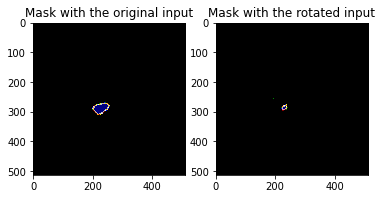

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'car', 'person']
accuracy : 0.9953755951498847


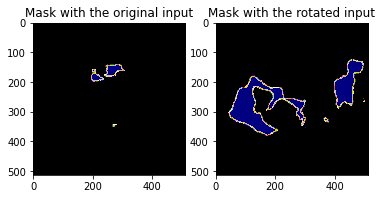

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.8892156750985108


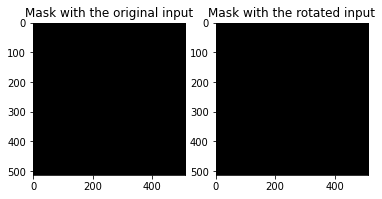

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background']
accuracy : 1.0


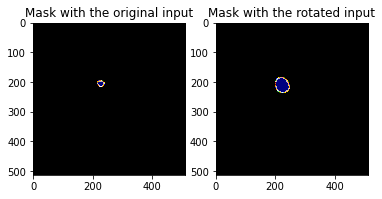

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9940304519149292


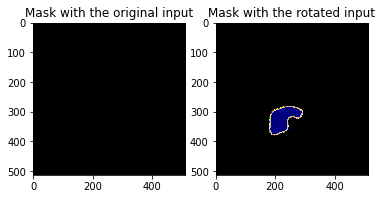

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9746550695560647


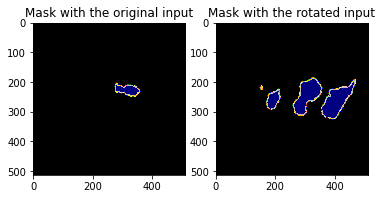

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9454685012292481


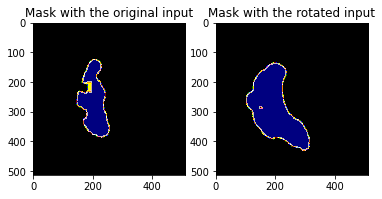

predicted classes with the original input :  ['background', 'bird', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9295851715057625


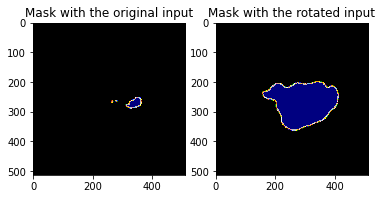

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.899760230118289


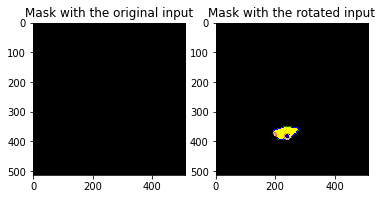

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background', 'bird', 'dog', 'person']
accuracy : 0.9890146635811968


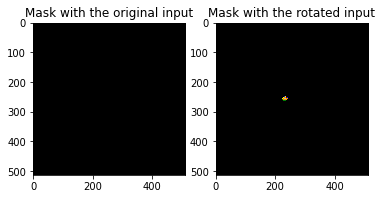

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background', 'cat']
accuracy : 0.9994072250151044


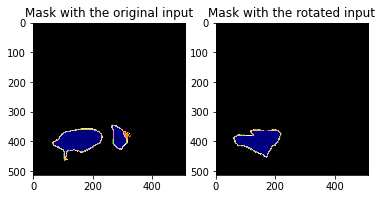

predicted classes with the original input :  ['background', 'car', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9753998381268311


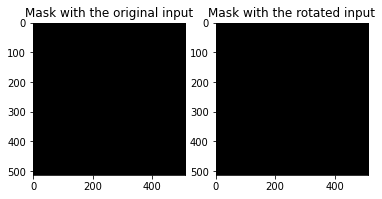

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background']
accuracy : 1.0


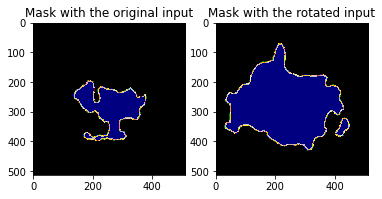

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.7928403421375618


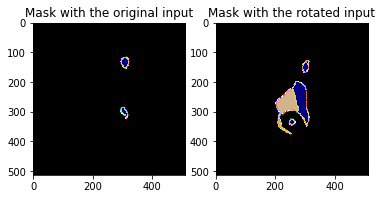

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'cat', 'dog', 'person']
accuracy : 0.9597558983010916


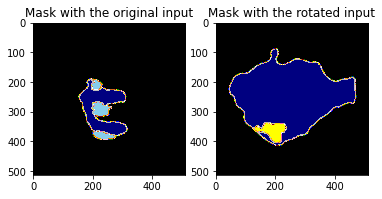

predicted classes with the original input :  ['background', 'cat', 'person']
predicted classes with the rotated input  :  ['background', 'bird', 'person']
accuracy : 0.7485532110544935


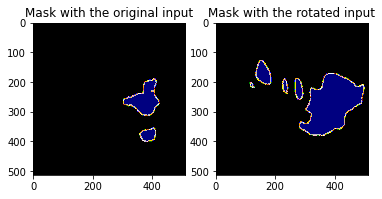

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.8997564302786423


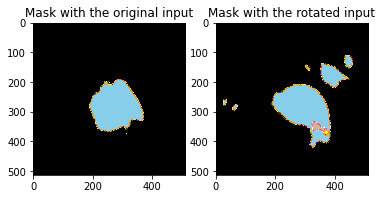

predicted classes with the original input :  ['background', 'cat']
predicted classes with the rotated input  :  ['background', 'bird', 'cat', 'dog']
accuracy : 0.9367858676363857


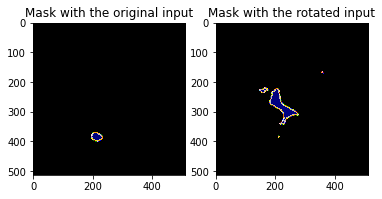

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.9812743902207327


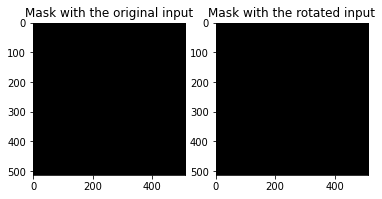

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background']
accuracy : 1.0


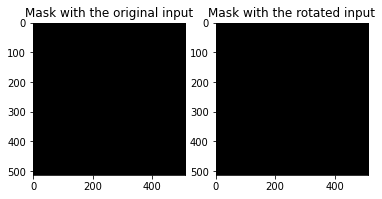

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background']
accuracy : 1.0


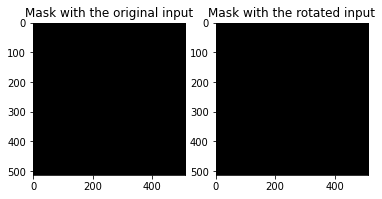

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background']
accuracy : 1.0


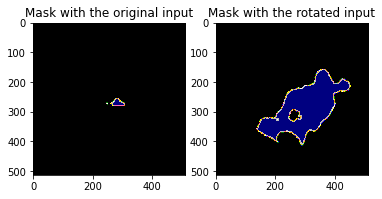

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.8767066029813542


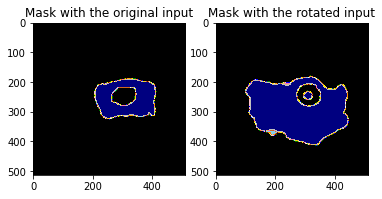

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'cat', 'dog', 'person']
accuracy : 0.8491653652215877


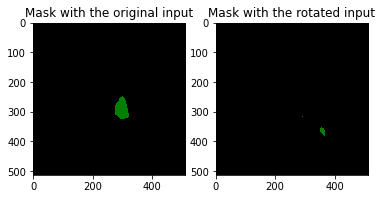

predicted classes with the original input :  ['background', 'aeroplane']
predicted classes with the rotated input  :  ['background', 'aeroplane']
accuracy : 0.985507411587231


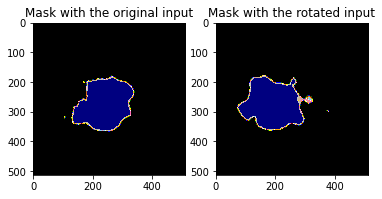

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'cat', 'dog', 'person']
accuracy : 0.9301019496977228


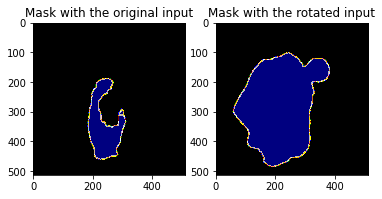

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.7736131535249212


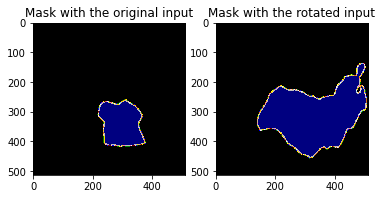

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.8417214793535713


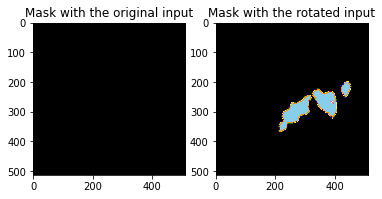

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background', 'cat', 'dog']
accuracy : 0.9540903373877623


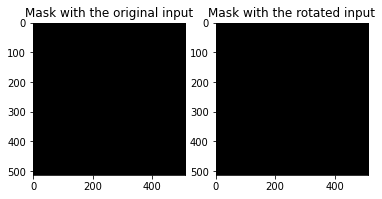

predicted classes with the original input :  ['background']
predicted classes with the rotated input  :  ['background']
accuracy : 1.0


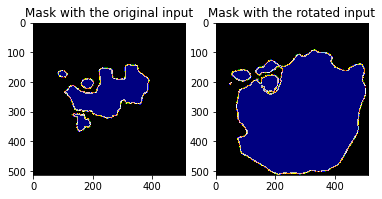

predicted classes with the original input :  ['background', 'person']
predicted classes with the rotated input  :  ['background', 'person']
accuracy : 0.5938351401570854


In [ ]:
acc_per_classes =\
eval_accuracy_equiv(model,dataloader_val,criterion=nn.KLDivLoss(reduction='mean'),nclass=21,device=device,plot=True)

In [ ]:
acc_per_classes